In [3]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST
# from stimage._model import CNN_NB_trainable
from stimage._data_generator import DataGenerator
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import scanpy as sc

In [4]:
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO

import json
import numpy as np
import pandas as pd
from matplotlib.image import imread
import tables
import anndata
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,
)
from anndata import read as read_h5ad
from scanpy._settings import settings
from scanpy._compat import Literal
from scanpy._utils import Empty, _empty
from scanpy import logging as logg

# .gz and .bz2 suffixes are also allowed for text formats
text_exts = {
    'csv',
    'tsv',
    'tab',
    'data',
    'txt',  # these four are all equivalent
}
avail_exts = {
    'anndata',
    'xlsx',
    'h5',
    'h5ad',
    'mtx',
    'mtx.gz',
    'soft.gz',
    'loom',
} | text_exts
"""Available file formats for reading data. """


# --------------------------------------------------------------------------------
# Reading and Writing data files and AnnData objects
# --------------------------------------------------------------------------------


def read(
    filename: Union[Path, str],
    backed: Optional[Literal['r', 'r+']] = None,
    sheet: Optional[str] = None,
    ext: Optional[str] = None,
    delimiter: Optional[str] = None,
    first_column_names: bool = False,
    backup_url: Optional[str] = None,
    cache: bool = False,
    cache_compression: Union[Literal['gzip', 'lzf'], None, Empty] = _empty,
    **kwargs,
) -> AnnData:
    """\
    Read file and return :class:`~anndata.AnnData` object.
    To speed up reading, consider passing ``cache=True``, which creates an hdf5
    cache file.
    Parameters
    ----------
    filename
        If the filename has no file extension, it is interpreted as a key for
        generating a filename via ``sc.settings.writedir / (filename +
        sc.settings.file_format_data)``.  This is the same behavior as in
        ``sc.read(filename, ...)``.
    backed
        If ``'r'``, load :class:`~anndata.AnnData` in ``backed`` mode instead
        of fully loading it into memory (`memory` mode). If you want to modify
        backed attributes of the AnnData object, you need to choose ``'r+'``.
    sheet
        Name of sheet/table in hdf5 or Excel file.
    ext
        Extension that indicates the file type. If ``None``, uses extension of
        filename.
    delimiter
        Delimiter that separates data within text file. If ``None``, will split at
        arbitrary number of white spaces, which is different from enforcing
        splitting at any single white space ``' '``.
    first_column_names
        Assume the first column stores row names. This is only necessary if
        these are not strings: strings in the first column are automatically
        assumed to be row names.
    backup_url
        Retrieve the file from an URL if not present on disk.
    cache
        If `False`, read from source, if `True`, read from fast 'h5ad' cache.
    cache_compression
        See the h5py :ref:`dataset_compression`.
        (Default: `settings.cache_compression`)
    kwargs
        Parameters passed to :func:`~anndata.read_loom`.
    Returns
    -------
    An :class:`~anndata.AnnData` object
    """
    filename = Path(filename)  # allow passing strings
    if is_valid_filename(filename):
        return _read(
            filename,
            backed=backed,
            sheet=sheet,
            ext=ext,
            delimiter=delimiter,
            first_column_names=first_column_names,
            backup_url=backup_url,
            cache=cache,
            cache_compression=cache_compression,
            **kwargs,
        )
    # generate filename and read to dict
    filekey = str(filename)
    filename = settings.writedir / (filekey + '.' + settings.file_format_data)
    if not filename.exists():
        raise ValueError(
            f'Reading with filekey {filekey!r} failed, '
            f'the inferred filename {filename!r} does not exist. '
            'If you intended to provide a filename, either use a filename '
            f'ending on one of the available extensions {avail_exts} '
            'or pass the parameter `ext`.'
        )
    return read_h5ad(filename, backed=backed)


def read_10x_h5(
    filename: Union[str, Path],
    genome: Optional[str] = None,
    gex_only: bool = True,
    backup_url: Optional[str] = None,
) -> AnnData:
    """\
    Read 10x-Genomics-formatted hdf5 file.
    Parameters
    ----------
    filename
        Path to a 10x hdf5 file.
    genome
        Filter expression to genes within this genome. For legacy 10x h5
        files, this must be provided if the data contains more than one genome.
    gex_only
        Only keep 'Gene Expression' data and ignore other feature types,
        e.g. 'Antibody Capture', 'CRISPR Guide Capture', or 'Custom'
    backup_url
        Retrieve the file from an URL if not present on disk.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    """
    start = logg.info(f'reading {filename}')
    is_present = _check_datafile_present_and_download(filename, backup_url=backup_url)
    if not is_present:
        logg.debug(f'... did not find original file {filename}')
    with tables.open_file(str(filename), 'r') as f:
        v3 = '/matrix' in f
    if v3:
        adata = _read_v3_10x_h5(filename, start=start)
        if genome:
            if genome not in adata.var['genome'].values:
                raise ValueError(
                    f"Could not find data corresponding to genome '{genome}' in '{filename}'. "
                    f'Available genomes are: {list(adata.var["genome"].unique())}.'
                )
            adata = adata[:, adata.var['genome'] == genome]
        if gex_only:
            adata = adata[:, adata.var['feature_types'] == 'Gene Expression']
        if adata.is_view:
            adata = adata.copy()
    else:
        adata = _read_legacy_10x_h5(filename, genome=genome, start=start)
    return adata


def _read_legacy_10x_h5(filename, *, genome=None, start=None):
    """
    Read hdf5 file from Cell Ranger v2 or earlier versions.
    """
    with tables.open_file(str(filename), 'r') as f:
        try:
            children = [x._v_name for x in f.list_nodes(f.root)]
            if not genome:
                if len(children) > 1:
                    raise ValueError(
                        f"'{filename}' contains more than one genome. For legacy 10x h5 "
                        "files you must specify the genome if more than one is present. "
                        f"Available genomes are: {children}"
                    )
                genome = children[0]
            elif genome not in children:
                raise ValueError(
                    f"Could not find genome '{genome}' in '{filename}'. "
                    f'Available genomes are: {children}'
                )
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            # AnnData works with csr matrices
            # 10x stores the transposed data, so we do the transposition right away
            from scipy.sparse import csr_matrix

            M, N = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']
            matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )
            # the csc matrix is automatically the transposed csr matrix
            # as scanpy expects it, so, no need for a further transpostion
            adata = AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['gene_names'].astype(str),
                    gene_ids=dsets['genes'].astype(str),
                ),
            )
            logg.info('', time=start)
            return adata
        except KeyError:
            raise Exception('File is missing one or more required datasets.')


def _read_v3_10x_h5(filename, *, start=None):
    """
    Read hdf5 file from Cell Ranger v3 or later versions.
    """
    with tables.open_file(str(filename), 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/matrix', 'Array'):
                dsets[node.name] = node.read()
            from scipy.sparse import csr_matrix

            M, N = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']
            matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )
            adata = AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['name'].astype(str),
                    gene_ids=dsets['id'].astype(str),
                    feature_types=dsets['feature_type'].astype(str),
                    genome=dsets['genome'].astype(str),
                ),
            )
            logg.info('', time=start)
            return adata
        except KeyError:
            raise Exception('File is missing one or more required datasets.')


def read_visium(
    path: Union[str, Path],
    genome: Optional[str] = None,
    *,
    count_file: str = "filtered_feature_bc_matrix.h5",
    library_id: str = None,
    load_images: Optional[bool] = True,
    source_image_path: Optional[Union[str, Path]] = None,
) -> AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    source_image_path
        Path to the high-resolution tissue image. Path will be included in
        `.uns["spatial"][library_id]["metadata"]["source_image_path"]`.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    path = Path(path)
    adata = read_10x_h5(path / count_file, genome=genome)

    adata.uns["spatial"] = dict()

    from h5py import File

    with File(path / count_file, mode="r") as f:
        attrs = dict(f.attrs)
    if library_id is None:
        library_id = str(attrs.pop("library_ids")[0], "utf-8")

    adata.uns["spatial"][library_id] = dict()

    if load_images:
        files = dict(
            tissue_positions_file=path / 'spatial/tissue_positions_list.csv',
            scalefactors_json_file=path / 'spatial/scalefactors_json.json',
            hires_image=path / 'spatial/tissue_hires_image.png',
            lowres_image=path / 'spatial/tissue_lowres_image.png',
        )

        # check if files exists, continue if images are missing
        for f in files.values():
            if not f.exists():
                if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                    logg.warning(
                        f"You seem to be missing an image file.\n"
                        f"Could not find '{f}'."
                    )
                else:
                    raise OSError(f"Could not find '{f}'")

        adata.uns["spatial"][library_id]['images'] = dict()
        for res in ['hires', 'lowres']:
            try:
                adata.uns["spatial"][library_id]['images'][res] = imread(
                    str(files[f'{res}_image'])
                )
            except Exception:
                raise OSError(f"Could not find '{res}_image'")

        # read json scalefactors
        adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
            files['scalefactors_json_file'].read_bytes()
        )

        adata.uns["spatial"][library_id]["metadata"] = {
            k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
            for k in ("chemistry_description", "software_version")
            if k in attrs
        }

        # read coordinates
        positions = pd.read_csv(files['tissue_positions_file'], header=None)
        positions.columns = [
            'barcode',
            'in_tissue',
            'array_row',
            'array_col',
            'pxl_col_in_fullres',
            'pxl_row_in_fullres',
        ]
        positions.index = positions['barcode']

        adata.obs = adata.obs.join(positions, how="left")

        adata.obsm['spatial'] = adata.obs[
            ['pxl_row_in_fullres', 'pxl_col_in_fullres']
        ].to_numpy()
        adata.obs.drop(
            columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
            inplace=True,
        )

        # put image path in uns
        if source_image_path is not None:
            # get an absolute path
            source_image_path = str(Path(source_image_path).resolve())
            adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
                source_image_path
            )

    return adata


def read_10x_mtx(
    path: Union[Path, str],
    var_names: Literal['gene_symbols', 'gene_ids'] = 'gene_symbols',
    make_unique: bool = True,
    cache: bool = False,
    cache_compression: Union[Literal['gzip', 'lzf'], None, Empty] = _empty,
    gex_only: bool = True,
    *,
    prefix: str = None,
) -> AnnData:
    """\
    Read 10x-Genomics-formatted mtx directory.
    Parameters
    ----------
    path
        Path to directory for `.mtx` and `.tsv` files,
        e.g. './filtered_gene_bc_matrices/hg19/'.
    var_names
        The variables index.
    make_unique
        Whether to make the variables index unique by appending '-1',
        '-2' etc. or not.
    cache
        If `False`, read from source, if `True`, read from fast 'h5ad' cache.
    cache_compression
        See the h5py :ref:`dataset_compression`.
        (Default: `settings.cache_compression`)
    gex_only
        Only keep 'Gene Expression' data and ignore other feature types,
        e.g. 'Antibody Capture', 'CRISPR Guide Capture', or 'Custom'
    prefix
        Any prefix before `matrix.mtx`, `genes.tsv` and `barcodes.tsv`. For instance,
        if the files are named `patientA_matrix.mtx`, `patientA_genes.tsv` and
        `patientA_barcodes.tsv` the prefix is `patientA_`.
        (Default: no prefix)
    Returns
    -------
    An :class:`~anndata.AnnData` object
    """
    path = Path(path)
    prefix = "" if prefix is None else prefix
    genefile_exists = (path / f'{prefix}genes.tsv').is_file()
    read = _read_legacy_10x_mtx if genefile_exists else _read_v3_10x_mtx
    adata = read(
        str(path),
        var_names=var_names,
        make_unique=make_unique,
        cache=cache,
        cache_compression=cache_compression,
        prefix=prefix,
    )
    if genefile_exists or not gex_only:
        return adata
    else:
        gex_rows = list(
            map(lambda x: x == 'Gene Expression', adata.var['feature_types'])
        )
        return adata[:, gex_rows].copy()


def _read_legacy_10x_mtx(
    path,
    var_names='gene_symbols',
    make_unique=True,
    cache=False,
    cache_compression=_empty,
    *,
    prefix="",
):
    """
    Read mex from output from Cell Ranger v2 or earlier versions
    """
    path = Path(path)
    adata = read(
        path / f'{prefix}matrix.mtx',
        cache=cache,
        cache_compression=cache_compression,
    ).T  # transpose the data
    genes = pd.read_csv(path / f'{prefix}genes.tsv', header=None, sep='\t')
    if var_names == 'gene_symbols':
        var_names = genes[1].values
        if make_unique:
            var_names = anndata.utils.make_index_unique(pd.Index(var_names))
        adata.var_names = var_names
        adata.var['gene_ids'] = genes[0].values
    elif var_names == 'gene_ids':
        adata.var_names = genes[0].values
        adata.var['gene_symbols'] = genes[1].values
    else:
        raise ValueError("`var_names` needs to be 'gene_symbols' or 'gene_ids'")
    adata.obs_names = pd.read_csv(path / f'{prefix}barcodes.tsv', header=None)[0].values
    return adata


def _read_v3_10x_mtx(
    path,
    var_names='gene_symbols',
    make_unique=True,
    cache=False,
    cache_compression=_empty,
    *,
    prefix="",
):
    """
    Read mtx from output from Cell Ranger v3 or later versions
    """
    path = Path(path)
    adata = read(
        path / f'{prefix}matrix.mtx.gz',
        cache=cache,
        cache_compression=cache_compression,
    ).T  # transpose the data
    genes = pd.read_csv(path / f'{prefix}features.tsv.gz', header=None, sep='\t')
    if var_names == 'gene_symbols':
        var_names = genes[1].values
        if make_unique:
            var_names = anndata.utils.make_index_unique(pd.Index(var_names))
        adata.var_names = var_names
        adata.var['gene_ids'] = genes[0].values
    elif var_names == 'gene_ids':
        adata.var_names = genes[0].values
#         adata.var['gene_symbols'] = genes[1].values
    else:
        raise ValueError("`var_names` needs to be 'gene_symbols' or 'gene_ids'")
#     adata.var['feature_types'] = genes[2].values
    adata.obs_names = pd.read_csv(path / f'{prefix}barcodes.tsv.gz', header=None)[
        0
    ].values
    return adata


def write(
    filename: Union[str, Path],
    adata: AnnData,
    ext: Optional[Literal['h5', 'csv', 'txt', 'npz']] = None,
    compression: Optional[Literal['gzip', 'lzf']] = 'gzip',
    compression_opts: Optional[int] = None,
):
    """\
    Write :class:`~anndata.AnnData` objects to file.
    Parameters
    ----------
    filename
        If the filename has no file extension, it is interpreted as a key for
        generating a filename via `sc.settings.writedir / (filename +
        sc.settings.file_format_data)`. This is the same behavior as in
        :func:`~scanpy.read`.
    adata
        Annotated data matrix.
    ext
        File extension from wich to infer file format. If `None`, defaults to
        `sc.settings.file_format_data`.
    compression
        See http://docs.h5py.org/en/latest/high/dataset.html.
    compression_opts
        See http://docs.h5py.org/en/latest/high/dataset.html.
    """
    filename = Path(filename)  # allow passing strings
    if is_valid_filename(filename):
        filename = filename
        ext_ = is_valid_filename(filename, return_ext=True)
        if ext is None:
            ext = ext_
        elif ext != ext_:
            raise ValueError(
                'It suffices to provide the file type by '
                'providing a proper extension to the filename.'
                'One of "txt", "csv", "h5" or "npz".'
            )
    else:
        key = filename
        ext = settings.file_format_data if ext is None else ext
        filename = _get_filename_from_key(key, ext)
    if ext == 'csv':
        adata.write_csvs(filename)
    else:
        adata.write(
            filename, compression=compression, compression_opts=compression_opts
        )


# -------------------------------------------------------------------------------
# Reading and writing parameter files
# -------------------------------------------------------------------------------


def read_params(
    filename: Union[Path, str], asheader: bool = False
) -> Dict[str, Union[int, float, bool, str, None]]:
    """\
    Read parameter dictionary from text file.
    Assumes that parameters are specified in the format::
        par1 = value1
        par2 = value2
    Comments that start with '#' are allowed.
    Parameters
    ----------
    filename
        Filename of data file.
    asheader
        Read the dictionary from the header (comment section) of a file.
    Returns
    -------
    Dictionary that stores parameters.
    """
    filename = str(filename)  # allow passing pathlib.Path objects
    from collections import OrderedDict

    params = OrderedDict([])
    for line in open(filename):
        if '=' in line:
            if not asheader or line.startswith('#'):
                line = line[1:] if line.startswith('#') else line
                key, val = line.split('=')
                key = key.strip()
                val = val.strip()
                params[key] = convert_string(val)
    return params


def write_params(path: Union[Path, str], *args, **maps):
    """\
    Write parameters to file, so that it's readable by read_params.
    Uses INI file format.
    """
    path = Path(path)
    if not path.parent.is_dir():
        path.parent.mkdir(parents=True)
    if len(args) == 1:
        maps[None] = args[0]
    with path.open('w') as f:
        for header, map in maps.items():
            if header is not None:
                f.write(f'[{header}]\n')
            for key, val in map.items():
                f.write(f'{key} = {val}\n')


# -------------------------------------------------------------------------------
# Reading and Writing data files
# -------------------------------------------------------------------------------


def _read(
    filename: Path,
    backed=None,
    sheet=None,
    ext=None,
    delimiter=None,
    first_column_names=None,
    backup_url=None,
    cache=False,
    cache_compression=None,
    suppress_cache_warning=False,
    **kwargs,
):
    if ext is not None and ext not in avail_exts:
        raise ValueError(
            'Please provide one of the available extensions.\n' f'{avail_exts}'
        )
    else:
        ext = is_valid_filename(filename, return_ext=True)
    is_present = _check_datafile_present_and_download(filename, backup_url=backup_url)
    if not is_present:
        logg.debug(f'... did not find original file {filename}')
    # read hdf5 files
    if ext in {'h5', 'h5ad'}:
        if sheet is None:
            return read_h5ad(filename, backed=backed)
        else:
            logg.debug(f'reading sheet {sheet} from file {filename}')
            return read_hdf(filename, sheet)
    # read other file types
    path_cache = settings.cachedir / _slugify(filename).replace(
        '.' + ext, '.h5ad'
    )  # type: Path
    if path_cache.suffix in {'.gz', '.bz2'}:
        path_cache = path_cache.with_suffix('')
    if cache and path_cache.is_file():
        logg.info(f'... reading from cache file {path_cache}')
        return read_h5ad(path_cache)

    if not is_present:
        raise FileNotFoundError(f'Did not find file {filename}.')
    logg.debug(f'reading {filename}')
    if not cache and not suppress_cache_warning:
        logg.hint(
            'This might be very slow. Consider passing `cache=True`, '
            'which enables much faster reading from a cache file.'
        )
    # do the actual reading
    if ext == 'xlsx' or ext == 'xls':
        if sheet is None:
            raise ValueError("Provide `sheet` parameter when reading '.xlsx' files.")
        else:
            adata = read_excel(filename, sheet)
    elif ext in {'mtx', 'mtx.gz'}:
        adata = read_mtx(filename)
    elif ext == 'csv':
        adata = read_csv(filename, first_column_names=first_column_names)
    elif ext in {'txt', 'tab', 'data', 'tsv'}:
        if ext == 'data':
            logg.hint(
                "... assuming '.data' means tab or white-space " 'separated text file',
            )
            logg.hint('change this by passing `ext` to sc.read')
        adata = read_text(filename, delimiter, first_column_names)
    elif ext == 'soft.gz':
        adata = _read_softgz(filename)
    elif ext == 'loom':
        adata = read_loom(filename=filename, **kwargs)
    else:
        raise ValueError(f'Unknown extension {ext}.')
    if cache:
        logg.info(
            f'... writing an {settings.file_format_data} '
            'cache file to speedup reading next time'
        )
        if cache_compression is _empty:
            cache_compression = settings.cache_compression
        if not path_cache.parent.is_dir():
            path_cache.parent.mkdir(parents=True)
        # write for faster reading when calling the next time
        adata.write(path_cache, compression=cache_compression)
    return adata


def _slugify(path: Union[str, PurePath]) -> str:
    """Make a path into a filename."""
    if not isinstance(path, PurePath):
        path = PurePath(path)
    parts = list(path.parts)
    if parts[0] == '/':
        parts.pop(0)
    elif len(parts[0]) == 3 and parts[0][1:] == ':\\':
        parts[0] = parts[0][0]  # C:\ → C
    filename = '-'.join(parts)
    assert '/' not in filename, filename
    assert not filename[1:].startswith(':'), filename
    return filename


def _read_softgz(filename: Union[str, bytes, Path, BinaryIO]) -> AnnData:
    """\
    Read a SOFT format data file.
    The SOFT format is documented here
    http://www.ncbi.nlm.nih.gov/geo/info/soft2.html.
    Notes
    -----
    The function is based on a script by Kerby Shedden.
    http://dept.stat.lsa.umich.edu/~kshedden/Python-Workshop/gene_expression_comparison.html
    """
    import gzip

    with gzip.open(filename, mode='rt') as file:
        # The header part of the file contains information about the
        # samples. Read that information first.
        samples_info = {}
        for line in file:
            if line.startswith("!dataset_table_begin"):
                break
            elif line.startswith("!subset_description"):
                subset_description = line.split("=")[1].strip()
            elif line.startswith("!subset_sample_id"):
                subset_ids = line.split("=")[1].split(",")
                subset_ids = [x.strip() for x in subset_ids]
                for k in subset_ids:
                    samples_info[k] = subset_description
        # Next line is the column headers (sample id's)
        sample_names = file.readline().strip().split("\t")
        # The column indices that contain gene expression data
        indices = [i for i, x in enumerate(sample_names) if x.startswith("GSM")]
        # Restrict the column headers to those that we keep
        sample_names = [sample_names[i] for i in indices]
        # Get a list of sample labels
        groups = [samples_info[k] for k in sample_names]
        # Read the gene expression data as a list of lists, also get the gene
        # identifiers
        gene_names, X = [], []
        for line in file:
            # This is what signals the end of the gene expression data
            # section in the file
            if line.startswith("!dataset_table_end"):
                break
            V = line.split("\t")
            # Extract the values that correspond to gene expression measures
            # and convert the strings to numbers
            x = [float(V[i]) for i in indices]
            X.append(x)
            gene_names.append(V[1])
    # Convert the Python list of lists to a Numpy array and transpose to match
    # the Scanpy convention of storing samples in rows and variables in colums.
    X = np.array(X).T
    obs = pd.DataFrame({"groups": groups}, index=sample_names)
    var = pd.DataFrame(index=gene_names)
    return AnnData(X=X, obs=obs, var=var, dtype=X.dtype)


# -------------------------------------------------------------------------------
# Type conversion
# -------------------------------------------------------------------------------


def is_float(string: str) -> float:
    """Check whether string is float.
    See also
    --------
    http://stackoverflow.com/questions/736043/checking-if-a-string-can-be-converted-to-float-in-python
    """
    try:
        float(string)
        return True
    except ValueError:
        return False


def is_int(string: str) -> bool:
    """Check whether string is integer."""
    try:
        int(string)
        return True
    except ValueError:
        return False


def convert_bool(string: str) -> Tuple[bool, bool]:
    """Check whether string is boolean."""
    if string == 'True':
        return True, True
    elif string == 'False':
        return True, False
    else:
        return False, False


def convert_string(string: str) -> Union[int, float, bool, str, None]:
    """Convert string to int, float or bool."""
    if is_int(string):
        return int(string)
    elif is_float(string):
        return float(string)
    elif convert_bool(string)[0]:
        return convert_bool(string)[1]
    elif string == 'None':
        return None
    else:
        return string


# -------------------------------------------------------------------------------
# Helper functions for reading and writing
# -------------------------------------------------------------------------------


def get_used_files():
    """Get files used by processes with name scanpy."""
    import psutil

    loop_over_scanpy_processes = (
        proc for proc in psutil.process_iter() if proc.name() == 'scanpy'
    )
    filenames = []
    for proc in loop_over_scanpy_processes:
        try:
            flist = proc.open_files()
            for nt in flist:
                filenames.append(nt.path)
        # This catches a race condition where a process ends
        # before we can examine its files
        except psutil.NoSuchProcess:
            pass
    return set(filenames)


def _get_filename_from_key(key, ext=None) -> Path:
    ext = settings.file_format_data if ext is None else ext
    return settings.writedir / f'{key}.{ext}'


def _download(url: str, path: Path):
    try:
        import ipywidgets
        from tqdm.auto import tqdm
    except ImportError:
        from tqdm import tqdm

    from urllib.request import urlopen, Request

    blocksize = 1024 * 8
    blocknum = 0

    try:
        with urlopen(Request(url, headers={"User-agent": "scanpy-user"})) as resp:
            total = resp.info().get("content-length", None)
            with tqdm(
                unit="B",
                unit_scale=True,
                miniters=1,
                unit_divisor=1024,
                total=total if total is None else int(total),
            ) as t, path.open("wb") as f:
                block = resp.read(blocksize)
                while block:
                    f.write(block)
                    blocknum += 1
                    t.update(len(block))
                    block = resp.read(blocksize)

    except (KeyboardInterrupt, Exception):
        # Make sure file doesn’t exist half-downloaded
        if path.is_file():
            path.unlink()
        raise


def _check_datafile_present_and_download(path, backup_url=None):
    """Check whether the file is present, otherwise download."""
    path = Path(path)
    if path.is_file():
        return True
    if backup_url is None:
        return False
    logg.info(
        f'try downloading from url\n{backup_url}\n'
        '... this may take a while but only happens once'
    )
    if not path.parent.is_dir():
        logg.info(f'creating directory {path.parent}/ for saving data')
        path.parent.mkdir(parents=True)

    _download(backup_url, path)
    return True


def is_valid_filename(filename: Path, return_ext=False):
    """Check whether the argument is a filename."""
    ext = filename.suffixes

    if len(ext) > 2:
        logg.warning(
            f'Your filename has more than two extensions: {ext}.\n'
            f'Only considering the two last: {ext[-2:]}.'
        )
        ext = ext[-2:]

    # cases for gzipped/bzipped text files
    if len(ext) == 2 and ext[0][1:] in text_exts and ext[1][1:] in ('gz', 'bz2'):
        return ext[0][1:] if return_ext else True
    elif ext and ext[-1][1:] in avail_exts:
        return ext[-1][1:] if return_ext else True
    elif ''.join(ext) == '.soft.gz':
        return 'soft.gz' if return_ext else True
    elif ''.join(ext) == '.mtx.gz':
        return 'mtx.gz' if return_ext else True
    elif not return_ext:
        return False
    raise ValueError(
        f'''\
{filename!r} does not end on a valid extension.
Please, provide one of the available extensions.
{avail_exts}
Text files with .gz and .bz2 extensions are also supported.\
'''
    )

In [5]:
def read_visium_(
    path: Union[str, Path],
    genome: Optional[str] = None,
    *,
    count_file = None,
    library_id: str = None,
    load_images: Optional[bool] = True,
    source_image_path: Optional[Union[str, Path]] = None,
) -> AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    source_image_path
        Path to the high-resolution tissue image. Path will be included in
        `.uns["spatial"][library_id]["metadata"]["source_image_path"]`.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    path = Path(path)
    adata = count_file

    adata.uns["spatial"] = dict()


    if library_id is None:
        library_id = str(attrs.pop("library_ids")[0], "utf-8")

    adata.uns["spatial"][library_id] = dict()

    if load_images:
        files = dict(
            tissue_positions_file=path / 'spatial/tissue_positions_list.csv',
            scalefactors_json_file=path / 'spatial/scalefactors_json.json',
            hires_image=path / 'spatial/tissue_hires_image.png',
            lowres_image=path / 'spatial/tissue_lowres_image.png',
        )

        # check if files exists, continue if images are missing
        for f in files.values():
            if not f.exists():
                if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                    logg.warning(
                        f"You seem to be missing an image file.\n"
                        f"Could not find '{f}'."
                    )
                else:
                    raise OSError(f"Could not find '{f}'")

        adata.uns["spatial"][library_id]['images'] = dict()
        for res in ['hires', 'lowres']:
            try:
                adata.uns["spatial"][library_id]['images'][res] = imread(
                    str(files[f'{res}_image'])
                )
            except Exception:
                raise OSError(f"Could not find '{res}_image'")

        # read json scalefactors
        adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
            files['scalefactors_json_file'].read_bytes()
        )


        # read coordinates
        positions = pd.read_csv(files['tissue_positions_file'], header=None)
        positions.columns = [
            'barcode',
            'in_tissue',
            'array_row',
            'array_col',
            'pxl_col_in_fullres',
            'pxl_row_in_fullres',
        ]
        positions.index = positions['barcode']

        adata.obs = adata.obs.join(positions, how="left")

        adata.obsm['spatial'] = adata.obs[
            ['pxl_row_in_fullres', 'pxl_col_in_fullres']
        ].to_numpy()
        adata.obs.drop(
            columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
            inplace=True,
        )

        # put image path in uns
        if source_image_path is not None:
            # get an absolute path
            source_image_path = str(Path(source_image_path).resolve())
            adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
                source_image_path
            )

    return adata

In [6]:
def sc_to_st(
    count_file=None,
    library_id: str = None,
    load_images: Optional[bool] = True,
    quality = "hires",
    image_path: Union[str, Path] = None,
) -> AnnData:

    """\
    Read Visium data from 10X (wrap read_visium from scanpy)
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    load_images
        Load image or not.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    image_path
        Path to image. Only need when loading full resolution image.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'fulres'`, `'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """

    adata = count_file
    adata.var_names_make_unique()

    if quality == "fulres":
        image_coor = adata.obsm["spatial"]
        img = plt.imread(image_path, 0)
        adata.uns["spatial"][library_id]["images"]["fulres"] = img
    else:
        scale = adata.uns["spatial"][library_id]["scalefactors"][
            "tissue_" + quality + "_scalef"
        ]
        image_coor = adata.obsm["spatial"] * scale

    adata.obs["imagecol"] = image_coor[:, 0]
    adata.obs["imagerow"] = image_coor[:, 1]
    adata.uns["spatial"][library_id]["use_quality"] = quality

    return adata

In [7]:
for i in ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535"]:
    print("gzip ./{}/filtered_count_matrix/barcodes.tsv".format(i))
    print("gzip ./{}/filtered_count_matrix/features.tsv".format(i))
    print("gzip ./{}/filtered_count_matrix/matrix.mtx".format(i))


    
#     print("mv ./{}/filtered_count_matrix/barcodes.tsv.gz ./{}/filtered_count_matrix/barcodes.tsv".format(i,i))
#     print("mv ./{}/filtered_count_matrix/features.tsv.gz ./{}/filtered_count_matrix/features.tsv".format(i,i))
#     print("mv ./{}/filtered_count_matrix/matrix.mtx.gz ./{}/filtered_count_matrix/matrix.mtx".format(i,i))
#     print("mkdir {}".format(i))
#     print("cp -r filtered_count_matrices/{}_filtered_count_matrix ./{}/filtered_count_matrix".format(i,i))
#     print("cp metadata/{}_metadata.csv ./{}/metadata.csv".format(i,i))
#     print("cp -r raw_count_matrices/{}_raw_feature_bc_matrix ./{}/raw_feature_bc_matrix".format(i,i))
#     print("cp -r spatial/{}_spatial ./{}/spatial".format(i,i))
#     print("cp {}.tif ./{}/".format(i,i))


gzip ./1142243F/filtered_count_matrix/barcodes.tsv
gzip ./1142243F/filtered_count_matrix/features.tsv
gzip ./1142243F/filtered_count_matrix/matrix.mtx
gzip ./1160920F/filtered_count_matrix/barcodes.tsv
gzip ./1160920F/filtered_count_matrix/features.tsv
gzip ./1160920F/filtered_count_matrix/matrix.mtx
gzip ./CID4290/filtered_count_matrix/barcodes.tsv
gzip ./CID4290/filtered_count_matrix/features.tsv
gzip ./CID4290/filtered_count_matrix/matrix.mtx
gzip ./CID4465/filtered_count_matrix/barcodes.tsv
gzip ./CID4465/filtered_count_matrix/features.tsv
gzip ./CID4465/filtered_count_matrix/matrix.mtx
gzip ./CID44971/filtered_count_matrix/barcodes.tsv
gzip ./CID44971/filtered_count_matrix/features.tsv
gzip ./CID44971/filtered_count_matrix/matrix.mtx
gzip ./CID4535/filtered_count_matrix/barcodes.tsv
gzip ./CID4535/filtered_count_matrix/features.tsv
gzip ./CID4535/filtered_count_matrix/matrix.mtx


In [9]:
BASE_PATH = Path("/scratch/imb/Xiao/Alex_NatGen_6BreastCancer")
TILE_PATH = Path("/tmp") / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)

SAMPLE = "1142243F"
mtx_adata = read_10x_mtx(BASE_PATH / SAMPLE / "filtered_count_matrix", var_names="gene_ids", gex_only=False)
Sample_sc = read_visium_(BASE_PATH / SAMPLE, count_file=mtx_adata, library_id=SAMPLE)
Sample_st = sc_to_st(count_file=Sample_sc, library_id=SAMPLE, quality="fulres",
                  image_path=BASE_PATH / SAMPLE / (SAMPLE+".tif"))
# img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
# Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img

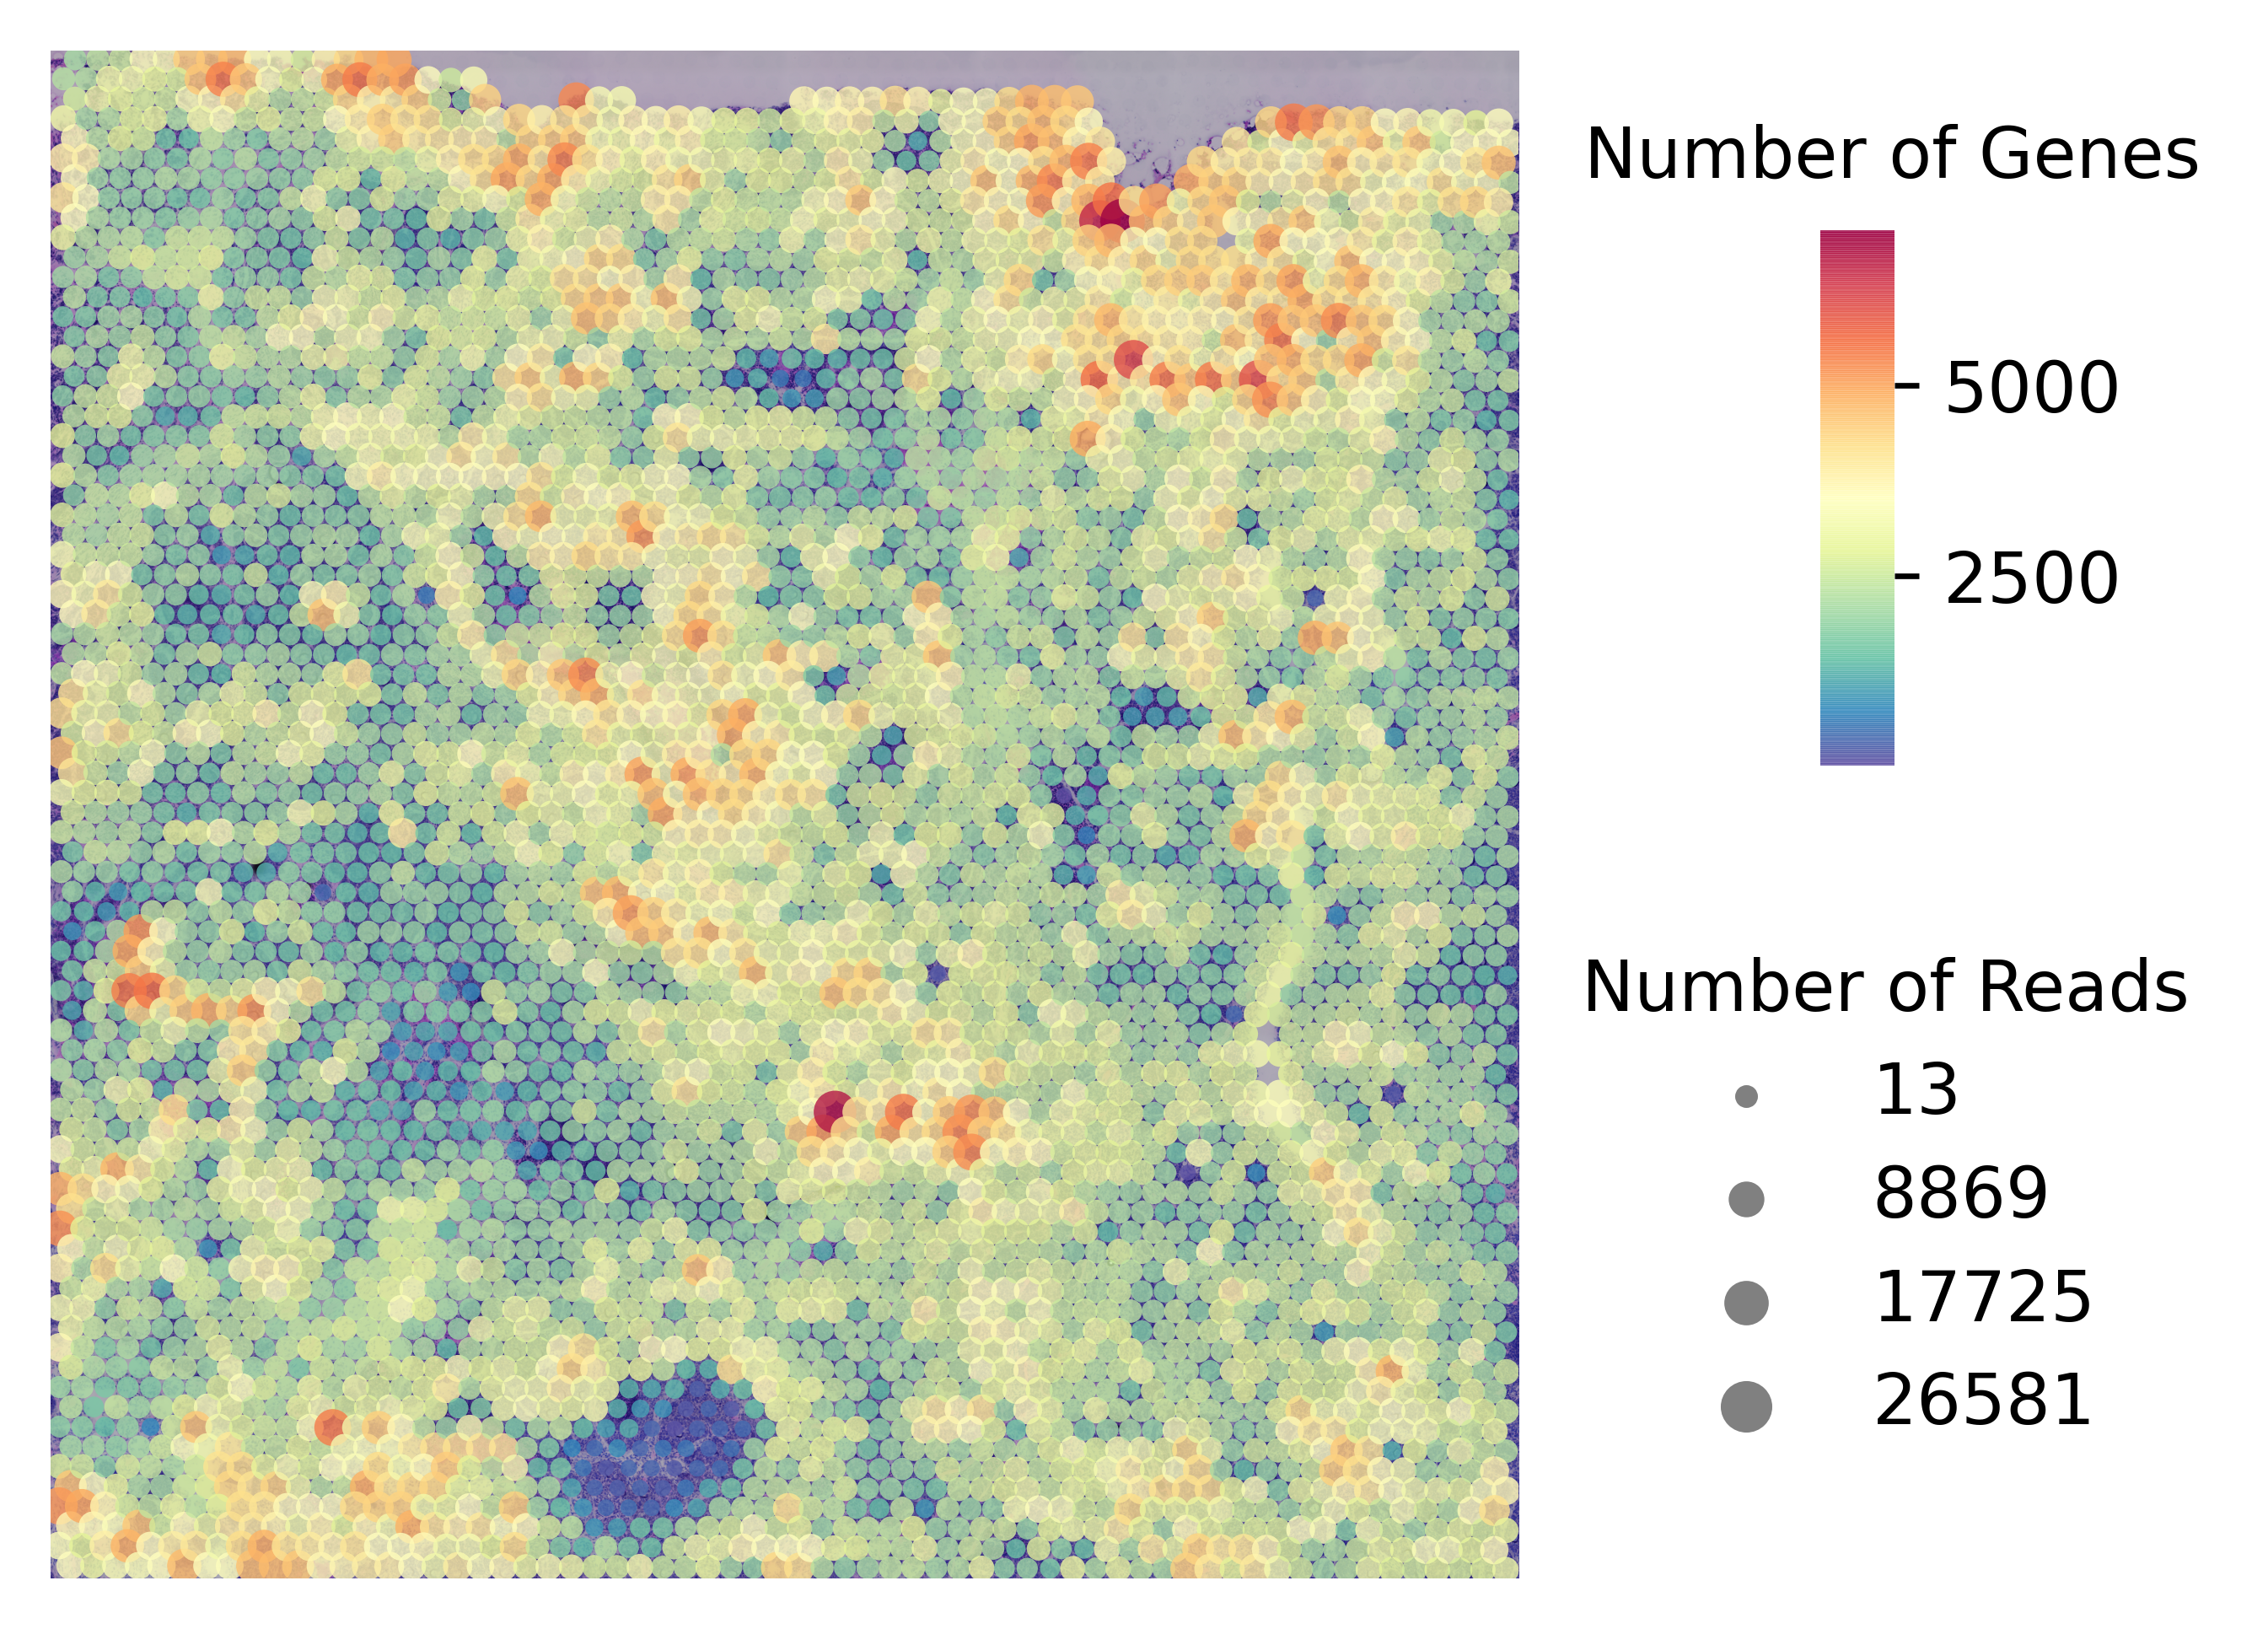

In [12]:
st.pl.QC_plot(Sample_st)

In [13]:
SAMPLE = "block1"
Sample1 = st.Read10X(Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium") / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium") / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
SAMPLE = "block2"
Sample2 = st.Read10X(Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium") / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium") / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
SAMPLE = "FFPE"
Sample3 = st.Read10X(Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium") / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(Path("/clusterdata/uqxtan9/Xiao/STimage/dataset/breast_cancer_10x_visium") / SAMPLE /"Visium_FFPE_Human_Breast_Cancer_image.tif", 0)
Sample3.uns["spatial"][SAMPLE]['images']["fulres"] = img

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
BASE_PATH = Path("/scratch/imb/Xiao/Alex_NatGen_6BreastCancer")
TILE_PATH = Path("/tmp") / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)

adata_list=[]
for i in ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535"]:
    SAMPLE = i
    mtx_adata = read_10x_mtx(BASE_PATH / SAMPLE / "filtered_count_matrix", var_names="gene_ids", gex_only=False)
    Sample_sc = read_visium_(BASE_PATH / SAMPLE, count_file=mtx_adata, library_id=SAMPLE)
    Sample_st = sc_to_st(count_file=Sample_sc, library_id=SAMPLE, quality="fulres",
                  image_path=BASE_PATH / SAMPLE / (SAMPLE+".tif"))
    adata_list.append(Sample_st)
    

In [18]:
adata_list.append(Sample1)
adata_list.append(Sample2)
adata_list.append(Sample3)

In [ ]:
for adata in adata_list:
    Sample = list(adata.uns["spatial"].keys())[0]
    
    print(Sample)
    adata.write_h5ad(f"/scratch/imb/Xiao/9visium_s_a/{Sample}_raw.h5ad")

In [3]:
import sys
from pathlib import Path
import anndata as ad

file=Path("/scratch/imb/Xiao/STimage/stimage").resolve()
parent=file.parent
sys.path.append(str(parent))
print(parent)

from stimage._img_normaliser import IterativeNormaliser
from stimage._utils import tiling, ensembl_to_id, ReadOldST, Read10X, scale_img, calculate_bg

/scratch/imb/Xiao/STimage


In [4]:
adata_list = []
for file in Path("/scratch/imb/Xiao/9visium_s_a").glob("./*_raw.h5ad"):
    adata = ad.re

/scratch/imb/Xiao/9visium_s_a/CID4290_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/block1_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/1160920F_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/FFPE_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/CID4465_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/1142243F_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/block2_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/CID4535_raw.h5ad
/scratch/imb/Xiao/9visium_s_a/CID44971_raw.h5ad


In [94]:
adata_list_norm = []
for adata in adata_list:
    Sample = list(adata.uns["spatial"].keys())[0]
    st.pp.log1p(adata)
    if Sample == "block1":
        template_img = adata.uns["spatial"][Sample]['images']["fulres"]
        template_img = Image.fromarray(template_img.astype("uint8"))

        normaliser = IterativeNormaliser(normalisation_method='vahadane', standardise_luminosity=True)
        normaliser.fit_target(scale_img(template_img))
    adata_list_norm.append(adata)

Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X
Log transformation step is finished in adata.X


In [98]:
DATA_PATH = Path("/scratch/imb/Xiao/breast_cancer_9visium")
TILING_PATH = DATA_PATH / "tiles"
TILING_PATH.mkdir(parents=True, exist_ok=True)
output_file = Path(DATA_PATH / "all_adata.h5ad")
tile_size = 299

In [99]:
tile_filtering_threshold = 0.7
for i, adata in enumerate(adata_list_norm):
    if tile_filtering_threshold < 1:
        print("filtering out tiles where tissue area less than {} of total tile area".format(
                    tile_filtering_threshold))
        calculate_bg(adata, crop_size=tile_size, stain_normaliser=normaliser)
        tile_to_remove = sum(adata.obs["tissue_area"] < tile_filtering_threshold)
        adata = adata[adata.obs["tissue_area"] >= tile_filtering_threshold].copy()
        print("{} tiles with low tissue coverage are removed".format(tile_to_remove))
        

    tiling(adata, out_path=TILING_PATH, crop_size=tile_size, stain_normaliser=normaliser)
    adata_list_norm[i] = adata
adata_all = adata_list_norm[0].concatenate(
            adata_list_norm[1:],
            batch_key="library_id",
            uns_merge="unique",
            batch_categories=[list(d.keys())[0]
                              for d in [adata_list_norm[i].uns["spatial"]
                                        for i in range(len(adata_list_norm))
                                        ]
                              ],
        )
adata_all.write(output_file)

filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


80 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


112 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


132 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


105 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


116 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


115 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


279 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


217 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]


filtering out tiles where tissue area less than 0.7 of total tile area


Tiling image: 100%|██████████ [ time left: 00:00 ]


180 tiles with low tissue coverage are removed


Tiling image: 100%|██████████ [ time left: 00:00 ]
/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types-FFPE' as categorical
/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome-FFPE' as categorical
/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` pa

In [72]:
list(Sample_st.uns["spatial"].keys())[0]

'CID4535'